In [1]:
# GAN (적대적 신경망)

from tensorflow import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 생성자 모델 (Generator)

generator = Sequential()
generator.add(Dense(128*7*7, input_dim = 100, activation=LeakyReLU(0.2)))
# 128 : 임의의 노드수, 7*7 upsampling >> 14*14 >> 28*28
# input_dim : 임의의 100차원 크기 random vector 준비해서 집어 넣겠다.
# activation = LeakyReLU(0.2) : 0보다 작으면 0.2 곱해서 출력
generator.add(BatchNormalization())
# 배치정규화 : 입력 데이터를 평균 0, 분산 1이 되게 재배치
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D()) # 14*14로 변환
generator.add(Conv2D(64, kernel_size = 5, padding = 'same'))
# 5*5 filter(kernel) 사용, padding = 'same' : zero padding
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D()) # 28*28로 변환
generator.add(Conv2D(1, kernel_size=5, padding = 'same', activation='tanh'))
# tanh >> -1 ~ 1 사이로 출력

In [3]:
# 판별자 모델

# --- Feature Extraction (특징 추출) ---
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding = 'same'))
# strides=2 >> pooling과정 대체 >> 가로/세로 크기가 더 줄어들어 새로운 특징 추출 효과
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
# ---------------------------------------
discriminator.add(Flatten()) # 2차원 >> 1차원
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss = 'binary_crossentropy', optimizer='adam')
discriminator.trainable = False
# 판별자 자신이 학습되지 않게 학습 기능 꺼줌 (매우 중요)


In [4]:
# GAN Network (생성자와 판별자 모델 연결)

ginput = Input(shape = (100,))
# 무작위로 100개의 vector 집어 넣음
dis_output = discriminator(generator(ginput))
# 생성된 28*28 이미지 판별자의 입력값으로 들어감
gan = Model(ginput, dis_output)
gan.compile(loss = 'binary_crossentropy', optimizer='adam')
# 참 거짓 분류(이진 분류)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [8]:
# 신경망을 실행시키는 함수 만들기

def gan_train(epoch, batch_size, saving_interval) :
    
    # MNIST 데이터를 불로옴
    (x_train, _), (_, _) = mnist.load_data()
    # mnist 데이터를 사용하되, 이미지만 사용하기 때문에 테스트 과정은 필요없으므로 x_train만 불러옴
    x_train = x_train.reshape(x_train.shape[0], 28,28,1).astype('float32')
    # 가로 세로 28*28, 흑백 : 1 로 설정
    x_train = (x_train - 127.5)/127.5
    # -1 ~ 1 사이로 스케일링
    
    # batch_size : 한 번에 몇개의 실제 이미지와 가상 이미지를 판별자에 넣을 지 결정
    true = np.ones((batch_size, 1))
    # 모두 참(1)인 배열 생성
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch) :
        # 실제 데이터를 판별자에 입력하는 부분
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        # 실제 이미지를 무작위하게 선택할 idx 만들기
        # 0부터 x_train.shape[0]까지 숫자를 batch_size 만큼 만들어줌
        
        imgs = x_train[idx]
        # 선택된 idx에 해당하는 이미지 불러오기
        
        d_loss_real = discriminator.train_on_batch(imgs, true)
        # 생성한 이미지와 모두 참(1)인 true 배열 y에 놓음
        # 여기에 차이가 발생하면 loss(손실)
        
        # 가상이미지를 판별자에 입력하는 부분
        noise = np.random.normal(0,1, (batch_size, 100))
        # 생성자에 넣을 가상 이미지 생성 >> noise
        # 정수가 아니기 때문에 정규분포 형태로 만들어줌
        # 0~1까지 batch_size만큼 100열을 뽑음
        
        gen_imgs = generator.predict(noise)
        # noise(생성된 가상이미지)가 생성자에 입력(예측), 결과값이 gen_imgs로 저장
        
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        # 만들어진 가짜 이미지(gen_imgs)에 fake 배열(모두 0) 레이블이 붙음
        
        # 판별자와 생성자의 오차 계산
        # d_loss_real, d_loss_fake 값을 더해서 둘로 나눈 평균 >> 판별자의 오차
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        g_loss = gan.train_on_batch(noise, true)
        
        print('epoch : %d'%i, '\td_loss : %.4f'%d_loss, '\tg_loss : %.4f'%g_loss)
        
        if i % saving_interval ==0 :
            # r, c = 5, 5
            noise = np.random.normal(0,1, (25,100))
            gen_imgs = generator.predict(noise)
            
            # rescale imgs 0~1
            gen_imgs = 0.5 * gen_imgs + 0.5
            
            fig, ax = plt.subplots(5, 5)
            count = 0
            for j in range(5) :
                for k in range(5) :
                    ax[j, k].imshow(gen_imgs[count, : , :, 0], cmap = 'gray')
                    ax[j, k].axis('off')
                    count += 1
            fig.savefig('./gan_img/gan_mnist_%d.png'%i)

1/1 [==============================] - 0s 191ms/step
epoch : 0 	d_loss : 0.7536 	g_loss:0.4818
1/1 [==============================] - 0s 13ms/step
epoch : 1 	d_loss : 0.5232 	g_loss:0.1627
1/1 [==============================] - 0s 12ms/step
epoch : 2 	d_loss : 0.5787 	g_loss:0.0681
1/1 [==============================] - 0s 12ms/step
epoch : 3 	d_loss : 0.5693 	g_loss:0.0920
1/1 [==============================] - 0s 12ms/step
epoch : 4 	d_loss : 0.4952 	g_loss:0.2428
1/1 [==============================] - 0s 13ms/step
epoch : 5 	d_loss : 0.4508 	g_loss:0.5394
1/1 [==============================] - 0s 12ms/step
epoch : 6 	d_loss : 0.4348 	g_loss:0.8908
1/1 [==============================] - 0s 12ms/step
epoch : 7 	d_loss : 0.4293 	g_loss:1.0919
1/1 [==============================] - 0s 12ms/step
epoch : 8 	d_loss : 0.4086 	g_loss:1.3050
1/1 [==============================] - 0s 12ms/step
epoch : 9 	d_loss : 0.3733 	g_loss:1.3015
1/1 [==============================] - 0s 13ms/step
epoch :

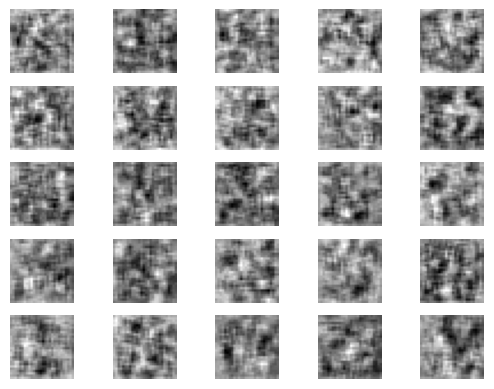

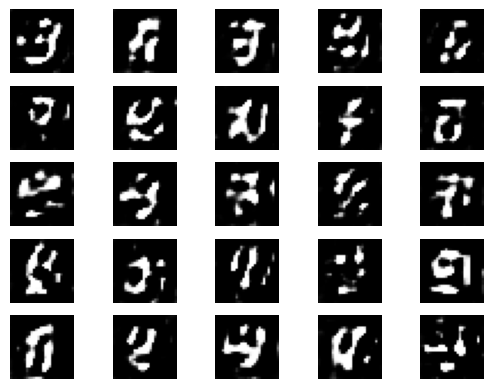

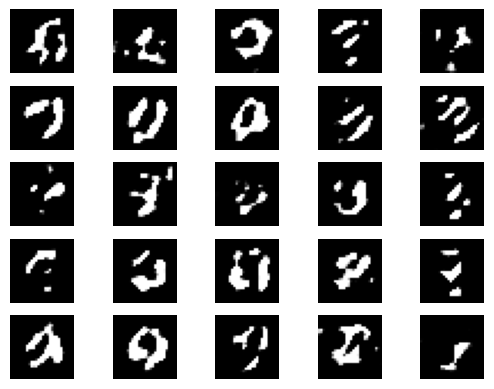

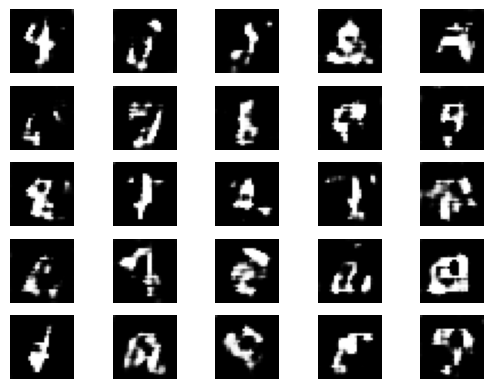

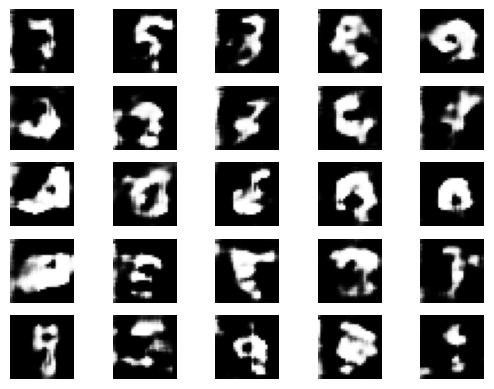

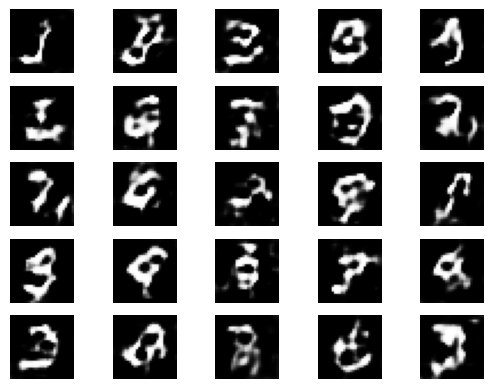

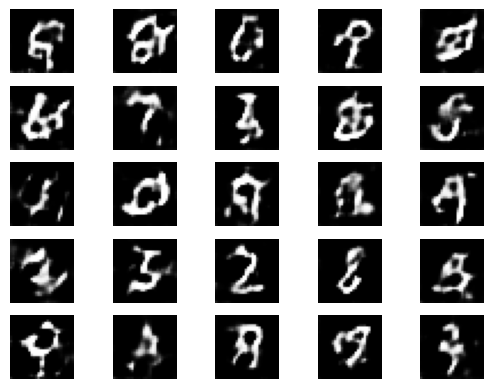

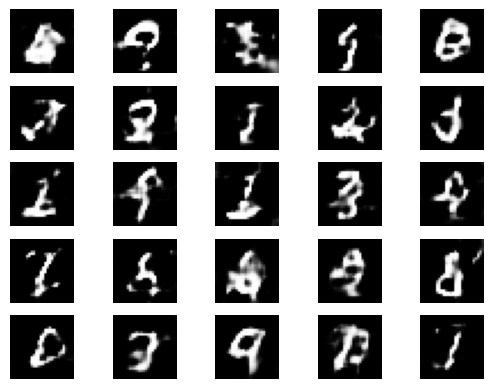

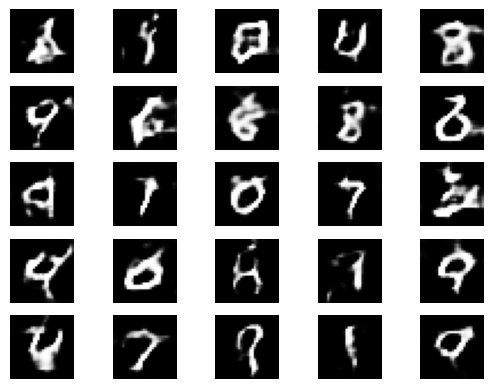

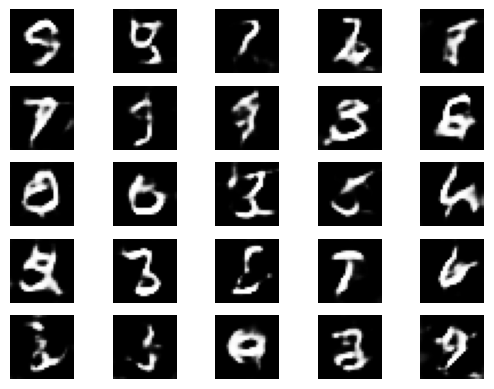

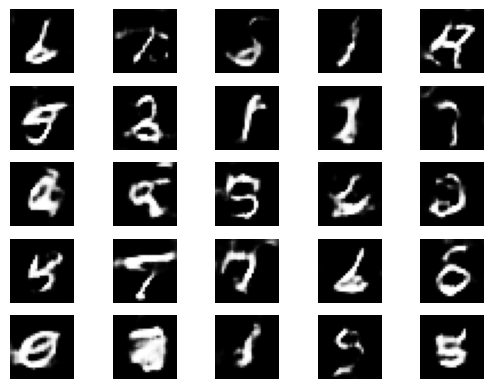

In [7]:
gan_train(2001, 32, 200)
# 2000번 반복, batch_size = 32